In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [7]:
data = pd.read_csv('../../ssd_data/final_data/final_MB1_30.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,6653.0,100.0,0.0,97.0,12707.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,4.976439e+10,99.0,3.939800e+10,0.0
1,2019-01-02,6653.0,100.0,0.0,97.0,12731.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.034821e+10,99.0,3.956458e+10,0.0
2,2019-01-03,6653.0,100.0,0.0,97.0,12755.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.082254e+10,99.0,3.973763e+10,0.0
3,2019-01-04,6653.0,100.0,0.0,97.0,12779.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.121309e+10,99.0,3.990997e+10,0.0
4,2019-01-05,6653.0,100.0,0.0,97.0,12803.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.157860e+10,99.0,4.008257e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71973,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
71974,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
71975,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
71976,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [8]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1
# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(244, 1)

In [9]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [10]:
import random
random.seed(42)

# 195개씩 랜덤하게 선택
healthy_disk_195 = random.sample(healthy_disk_list, 195)
failure_disk_195 = random.sample(failure_disk_list, 195)

print(len(healthy_disk_195))
print(len(failure_disk_195))

# 195개에서 146/49 개로 validation set 구축
healthy_disk_146 = random.sample(healthy_disk_195,146) #train set
healthy_disk_49 = list(set(healthy_disk_195) - set(healthy_disk_146)) #validation set

failure_disk_146 = random.sample(failure_disk_195, 146) #train set
failure_disk_49 = list(set(failure_disk_195) - set(failure_disk_146)) #validation set

print('train_healthy_count:', len(healthy_disk_146))
print('train_failure_count:', len(failure_disk_146))

print('val_healthy_count:', len(healthy_disk_49))
print('val_failure_count:',len(failure_disk_49))
# 49개씩 랜덤하게 선택
test_healthy_disk_49 = list(set(healthy_disk_list) - set(healthy_disk_195)) # test set
test_failure_disk_49 = list(set(failure_disk_list) - set(failure_disk_195)) # test set

print('test_healthy_count:',len(test_healthy_disk_49))
print('test_healthy_count:',len(test_failure_disk_49))

195
195
train_healthy_count: 146
train_failure_count: 146
val_healthy_count: 49
val_failure_count: 49
test_healthy_count: 49
test_healthy_count: 49


In [15]:
H_disk_195 = data[data['disk_id'].isin(healthy_disk_195)]
F_disk_195 = data[data['disk_id'].isin(failure_disk_195)]

H_disk_146 = data[data['disk_id'].isin(healthy_disk_146)]
F_disk_146 = data[data['disk_id'].isin(failure_disk_146)]

H_disk_49 = data[data['disk_id'].isin(healthy_disk_49)]
F_disk_49 = data[data['disk_id'].isin(failure_disk_49)]

test_H_disk_49 = data[data['disk_id'].isin(test_healthy_disk_49)]
test_F_disk_49 = data[data['disk_id'].isin(test_failure_disk_49)]

# train set, validation set, test set 생성
final_train_set = pd.concat([H_disk_195,F_disk_195],ignore_index=True,axis=0) #validation set으로 최적의 epoch 찾은 후, 해당 epoch으로 다시 training 시킬 예정
train_set = pd.concat([H_disk_146,F_disk_146],ignore_index=True,axis=0)
val_set = pd.concat([H_disk_49,F_disk_49],ignore_index=True,axis=0)
test_set = pd.concat([test_H_disk_49,test_F_disk_49],ignore_index=True,axis=0)

In [18]:
# feature와 label 구분
final_X_train = final_train_set.drop(columns=['disk_id','index','label'])
X_train = train_set.drop(columns=['disk_id','index','label'])
X_val = val_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

final_y_train = final_train_set['label']
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

In [17]:
# Random Forest 모델 생성
rf = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150)

In [19]:
rf.fit(final_X_train,final_y_train)

RandomForestClassifier(max_depth=20, n_estimators=150)

In [20]:
# Test 세트를 사용하여 최종 모델의 성능 평가
y_pred = rf.predict(X_test)

In [22]:
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Macro F1-score on Test Set:", f1_score(y_test, y_pred, average='macro'))
print("Precision on Test Set:", precision_score(y_test, y_pred))
print("Recall on Test Set:", recall_score(y_test, y_pred))

Accuracy on Test Set: 0.9328728540772532
Macro F1-score on Test Set: 0.7915058213825834
Precision on Test Set: 0.7016337059329321
Recall on Test Set: 0.5551020408163265


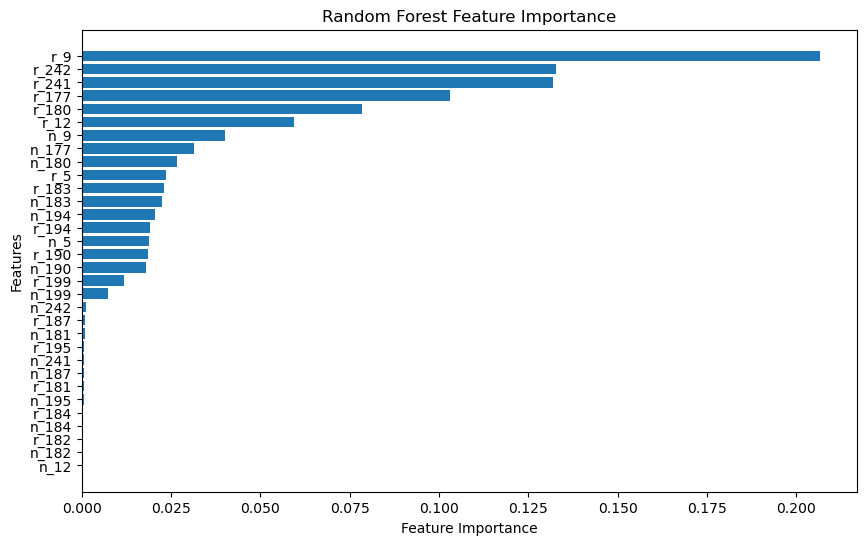

In [23]:
# Feature Importance 시각화
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

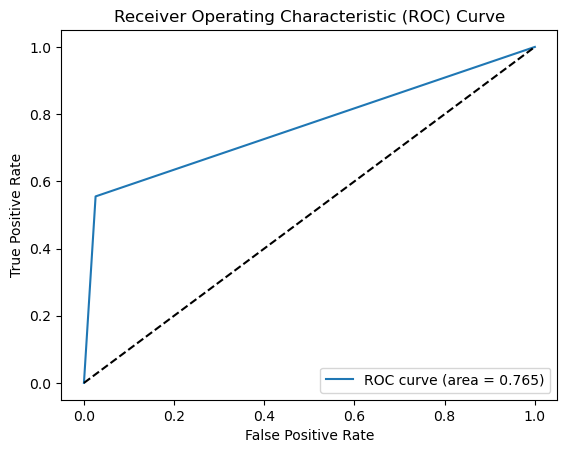

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = rf.predict(X_test) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

=================================================================================================================

## Validation을 통한 best model 찾기

In [46]:
from tqdm import tqdm 

def train_and_evaluate(final_X_train, final_y_train ,X_train, y_train, X_val , y_val, X_test, y_test):
    # Initialize the model
    model = RandomForestClassifier(random_state=42)

    # Create a parameter grid
    param_grid = {'n_estimators': [100, 500],
                  'max_depth': [5, 10, 20],
                  'min_samples_split': [2, 10, 15],
                  'min_samples_leaf': [1, 5, 10]}

    # Naive Grid Search
    best_roc_auc, best_params = float('0'), None
    for n_estimators in tqdm(param_grid['n_estimators']):
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    model.set_params(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                    model.fit(X_train, y_train)
                    preds = model.predict(X_val)
                    fpr, tpr, thresholds = roc_curve(y_val, preds)
                    current_roc_auc = auc(fpr, tpr)
                    #current_roc_auc = f1_score(y_val, preds, average='macro')

                    if current_roc_auc > best_roc_auc:
                        best_roc_auc = current_roc_auc
                        best_params = (n_estimators, max_depth, min_samples_split, min_samples_leaf)

    # Best model
    model.set_params(n_estimators=best_params[0], max_depth=best_params[1], min_samples_split=best_params[2], min_samples_leaf=best_params[3])
    model.fit(final_X_train, final_y_train)

    y_pred = model.predict(X_test)

    print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
    print("Macro F1-score on Test Set:", f1_score(y_test, y_pred, average='macro'))
    print("Precision on Test Set:", precision_score(y_test, y_pred))
    print("Recall on Test Set:", recall_score(y_test, y_pred))

    return model, best_params

In [47]:
best_model, best_params = train_and_evaluate(final_X_train, final_y_train ,X_train, y_train, X_val , y_val, X_test, y_test)

100%|██████████| 2/2 [12:23<00:00, 371.60s/it]


Accuracy on Test Set: 0.9271727467811158
Macro F1-score on Test Set: 0.7718429794094417
Precision on Test Set: 0.6687170474516696
Recall on Test Set: 0.5176870748299319


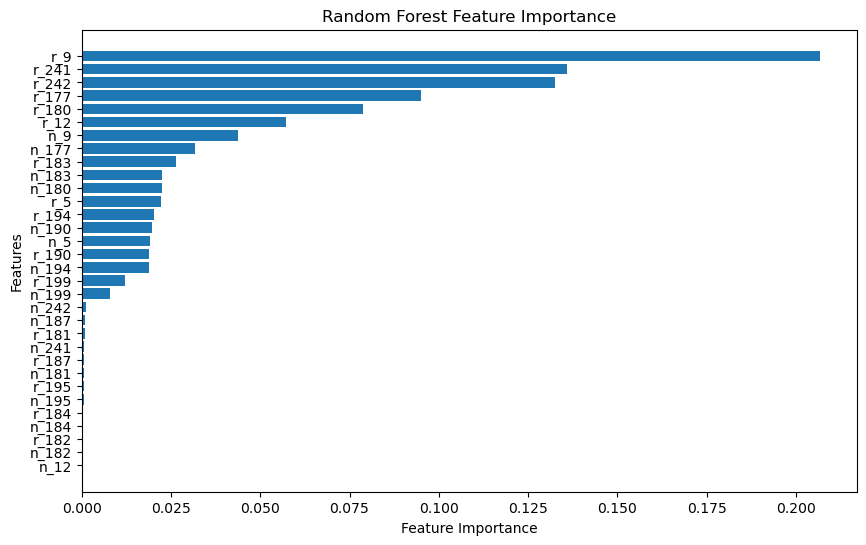

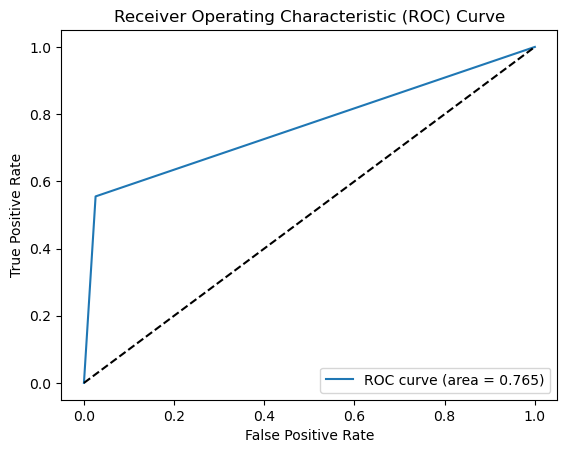

In [48]:
# Feature Importance 시각화
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()